# Weather Prediction and Learning AdaBoost

#### This is an excerpt from my code for a Machine Learning and Statistical Analysis problem set (COSC 274) where I train a classifier to predict the weather and implement AdaBoost to improve prediction accuracy. The source of the meterological data was not credited in the problem set.¶

The data consists of various meterological measurements (from the Weather.csv file), including whether or not it rained the following day. The objectives of the problem set were to 1) train a classifier to accurately predict whether it will rain the following day on unseen test data where the value was withheld and 2) construct the AdaBoost algorithm from scratch, implement it with the trained classifiers, and observe how it impacts the classifier prediction accuracy

Here, I have replaced the AdaBoost algorithm I wrote from scratch with scikit learn's Adaboost function in case this problem set is used again in the future for the course (so it cannot be used).

#### What is AdaBoost?

The basic idea behind the algorithm is that it attempts to learn from "tricky" samples incorrectly classified during training to improve prediction accuracy. It implements a base classifier (a decision tree in this case) and trains the base classifier on a subset of data. After fitting the classifier, it identifies samples it classified incorrectly and assigns "weights" to learn from these tricky samples. The algorithm does this over a number of iterations where the weights for samples are continuously updated based upon if they are identified correctly or not.

Here is the AdaBoost algorithm explained by Robert Schapire in "Explaining AdaBoost":
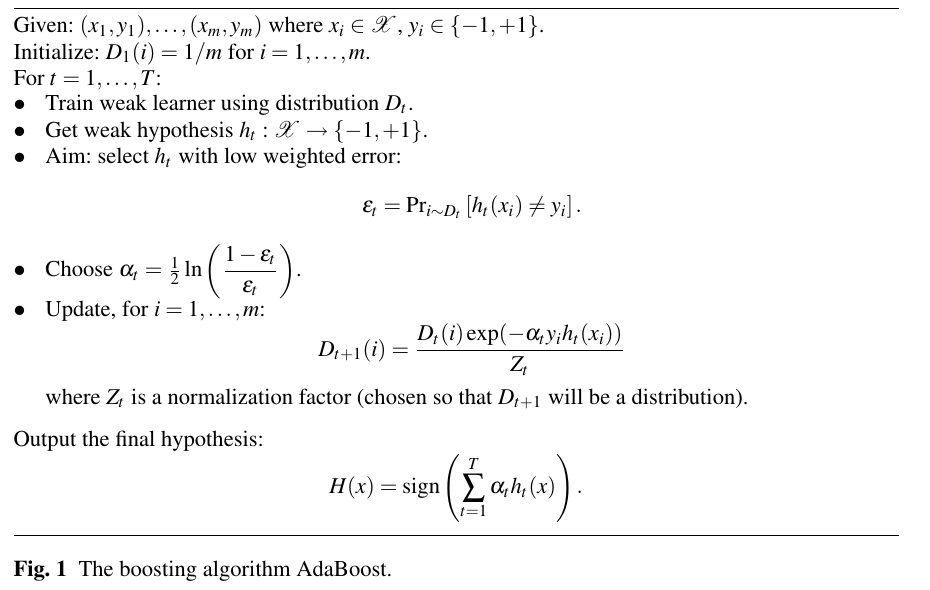

## Import Statements

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
import seaborn as sns
from scipy import sparse
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score,recall_score,precision_score, make_scorer
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import StratifiedKFold

## Read Data, Change String Values to Integers, Remove NaN's

In [2]:
dft = pd.read_csv('Weather.csv')
dft.head()

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,17.3,24.5,0.0,ENE,30,W,NE,9,13,79,69,1023.1,1019.1,20.2,24.1,No,No
1,12.2,20.9,0.4,W,26,W,NNE,20,13,78,52,1025.5,1021.6,13.6,20.6,No,No
2,20.1,27.0,0.2,NNE,43,ENE,NE,9,22,78,62,1010.8,1008.5,23.3,26.5,No,No
3,9.5,19.0,21.6,NaN,0,W,ESE,15,15,69,51,1016.4,1014.1,14.1,18.3,Yes,No
4,22.9,28.3,0.0,NaN,0,ESE,NE,4,24,79,63,1016.3,1012.2,24.8,27.1,No,No


In [4]:
#Change string values to unique integer values for training and test data
label1,index1 = pd.factorize(dft['RainToday'])
dft['RainToday'] = label1
label2,index2 = pd.factorize(dft['RainTomorrow'])
dft['Target'] = label2
label3,index3 = pd.factorize(dft['WindGustDir'])
dft['WindGustDir']= label3
label4,index4 = pd.factorize(dft['WindDir9am'])
dft['WindDir9am']= label4
label5,index5 = pd.factorize(dft['WindDir3pm'])
dft['WindDir3pm']= label5

In [5]:
dft = dft.drop(['RainTomorrow'],axis=1)
#Remove NaN's and verify that they're all gone
dft = dft.dropna(axis='rows')
dft.isnull().values.any()

False

## Check for Class Imbalanmce

0    1864
1     636
Name: Target, dtype: int64

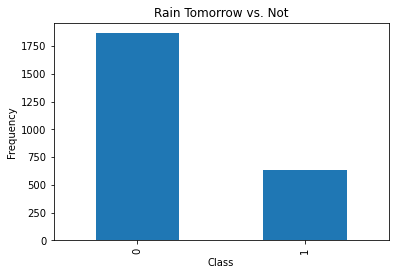

In [6]:
pd.value_counts(dft['Target']).plot.bar()
plt.title('Rain Tomorrow vs. Not')
plt.xlabel('Class')
plt.ylabel('Frequency')
dft['Target'].value_counts()

Note how there is fairly significant class imbalance with our Target variable- we will address this later on during training!

## Explore features that are correlated with one another and the Target variable

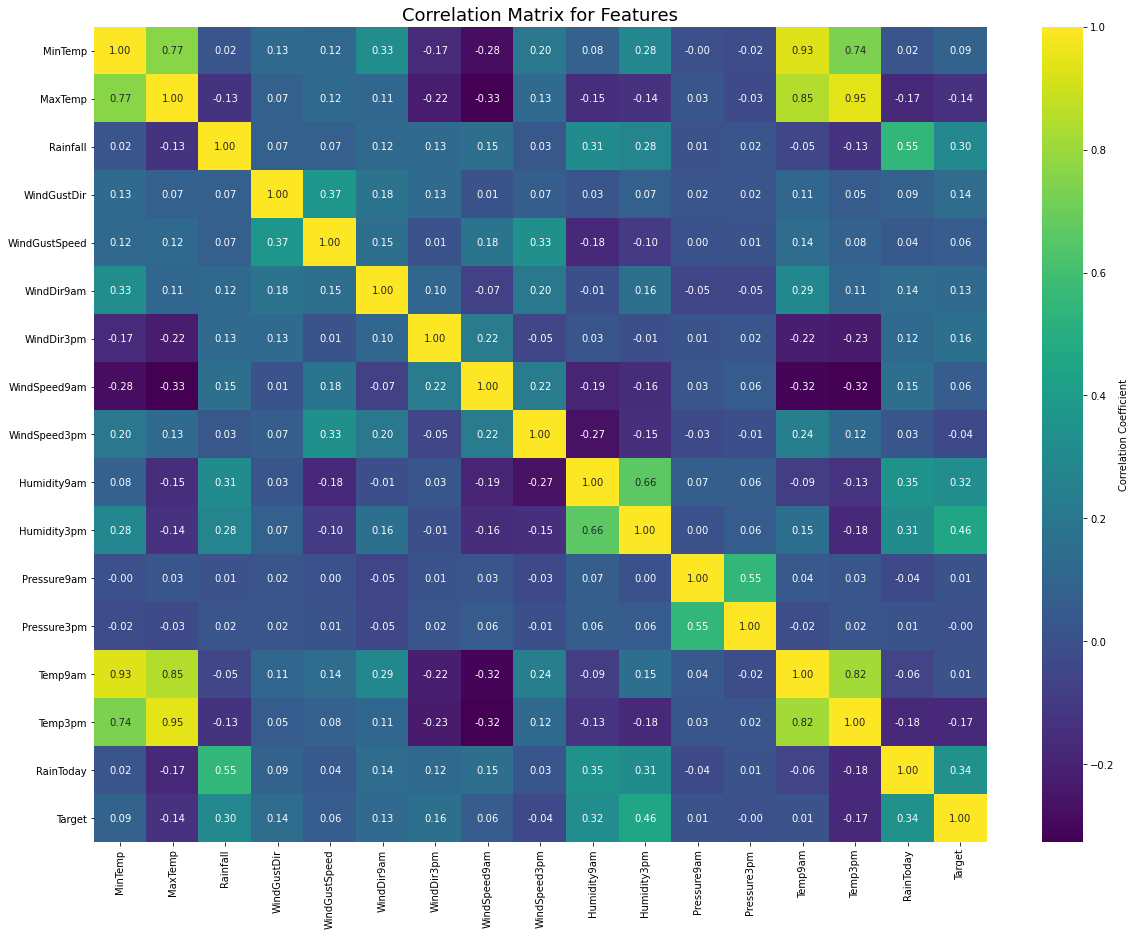

In [7]:
#plot a heatmap of correlation coefficients for different features 
f, ax = plt.subplots(figsize= [20,15])
sns.heatmap(dft.corr(), annot=True, fmt=".2f", ax=ax, cbar_kws={'label': 'Correlation Coefficient'}, cmap='viridis')
ax.set_title("Correlation Matrix for Features", fontsize=18)
plt.show()

interestingly, the highest correlation with the target variable (whether it will rain tomorrow) is the Humidity3pm (FYI I am not a meteorologist). Note how many of the variables in the dataset are, unsurprisingly, correlated with one another (e.g. Temp3pm and Temp9am)

## Dimensionality Reduction

In order to reduce the dimensionality of the 16-feature dataset to more easily explore the feature space, I use principal component analysis (PCA) on a subset of the features to explore which features explain the most variance in the dataset.

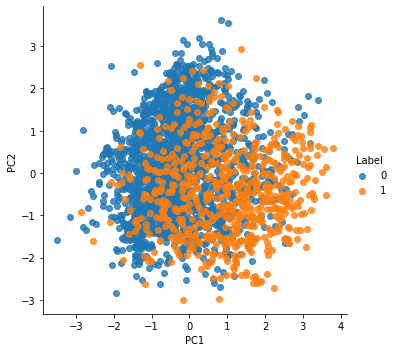

In [9]:
#Principal Component Analysis
pca = make_pipeline(StandardScaler(), PCA(n_components=2))
dft2 = dft[['Temp9am','RainToday','Humidity3pm','WindDir3pm',
           'WindSpeed3pm','WindGustDir']]
x = dft2.values 
y = dft['Target'].values
pca.fit(x,y)                      
X_2D = pca.transform(x)    
dft_pca = pd.DataFrame(data=X_2D)
dft_pca['Label'] = y
dft_pca.columns = ['PC1', 'PC2','Label']
sns.lmplot('PC1', 'PC2', hue='Label', data=dft_pca, fit_reg=False);

notice how the reprojected data in PC1 and PC2 still overlap quite a lot- this highlights how the first and second principal components, which define new uncorrelated axes along which the maximum variance is explained, are not able to entirely discriminate between the Target variable (rain vs. not raining tomorrow) in the new reprojected feature space. 

Below we see that RainToday and Humidity3pm correlate highest with PC1, while Temp9am and MinTemp have the highest negative correlation with PC2.

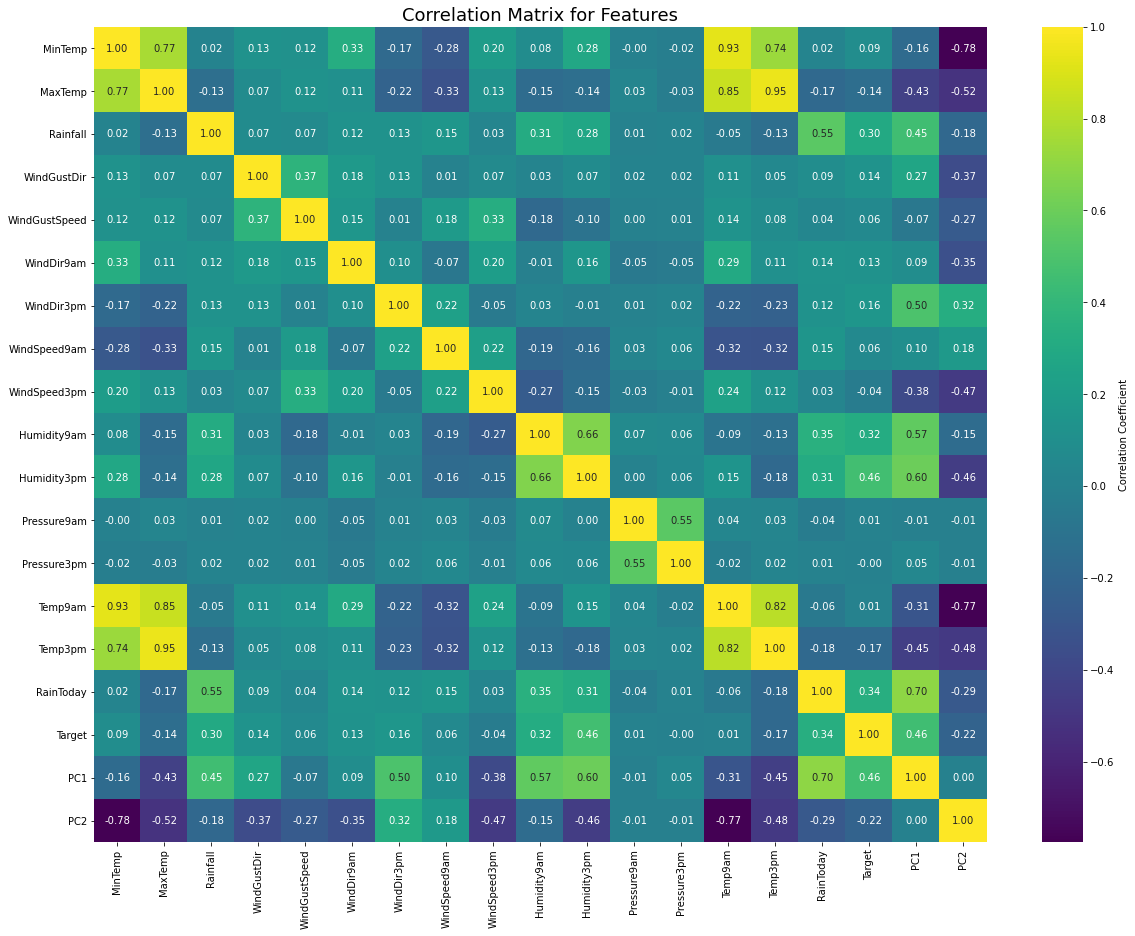

In [32]:
dft['PC1'] = dft_pca['PC1']
dft['PC2'] = dft_pca['PC2']

f, ax = plt.subplots(figsize= [20,15])
sns.heatmap(dft.corr(), annot=True, fmt=".2f", ax=ax, cbar_kws={'label': 'Correlation Coefficient'}, cmap='viridis')
ax.set_title("Correlation Matrix for Features", fontsize=18)
plt.show()

## Feature Combinations

To test whether certain combinations of features might produce better results than training the classifier on single features, I create variables consisting of different combinations of features

In [14]:
#pass feature vectors from pd dataframe to numpy array for combination
humidity = np.array(dft['Humidity3pm']).flatten()
rain_today = np.array(dft['RainToday']).flatten()
temp = np.array(dft['Temp9am']).flatten()
windspeed = np.array(dft['WindSpeed3pm']).flatten()
winddir = np.array(dft['WindDir3pm']).flatten()
windgust = np.array(dft['WindGustDir']).flatten()
pc1 = np.array(dft_pca['PC1']).flatten()
pc2 = np.array(dft_pca['PC2']).flatten()

In [16]:
#"stack" matrices together to form combined features for training
humidity_rain = np.stack((humidity,rain_today),axis=1)
humidity_rain_temp = np.stack((humidity,rain_today,temp),axis=1)
combined = np.stack((rain_today,humidity,temp,winddir,windspeed,
                     windgust),axis=1)
pc = np.stack((pc1,pc2),axis=1)
humidity_rain_temp_wind = np.stack((humidity,rain_today,temp,winddir),axis=1)

In [17]:
#pass individual features into np arrays for training
humidity = dft['Humidity3pm'].to_numpy()
rain_today = dft['RainToday'].to_numpy()
temp = dft['Temp9am'].to_numpy()
windspeed = dft['WindSpeed3pm'].to_numpy()
winddir = dft['WindDir3pm'].to_numpy()
windgust = dft['WindGustDir'].to_numpy()
pc1 = dft_pca['PC1'].to_numpy()
pc2 = dft_pca['PC2'].to_numpy()

## Test Which Features are Best for Training

Test feature combinations by training decision tree classifier on different combinations and evaluate by comparing their F1 Score. Notice I use SMOTE to oversample the class 1 (no rain) since there is fairly significant class imbalance in the dataset

In [18]:
f1 = []
y_trainer = dft['Target'].to_numpy()

#reshape non-combined feature numpy arrays for being passed to classifer
X_train0 = humidity.reshape(-1,1)
X_train1 = rain_today.reshape(-1,1)
X_train2 = temp.reshape(-1,1)
X_train3 = windspeed.reshape(-1,1)
X_train4 = winddir.reshape(-1,1)
X_train5 = windgust.reshape(-1,1)
X_train6 = pc1.reshape(-1,1)
X_train7 = pc2.reshape(-1,1)
X_train10 = humidity_rain
X_train11 = humidity_rain_temp
X_train12 = combined
X_train13 = pc
X_train15 = humidity_rain_temp_wind

#test using decision tree classifier with SMOTE
clf3 = DecisionTreeClassifier()
oversample = SMOTE(k_neighbors=2)

#create dictionary to store variable names
dict = {'X_train0': X_train0, 'X_train1': X_train1, 'X_train2': X_train2, 'X_train3': X_train3, 'X_train4': X_train4,
        'X_train5' : X_train5,'X_train6' : X_train6, 'X_train7' : X_train7, 'X_train10' : X_train10,
        'X_train11' : X_train11, 'X_train12' : X_train12, 'X_train13' : X_train13, 'X_train15' : X_train15}

#loop through dictionary classifying each feature and storing 10-fold CV F1 score
for feature in dict.values():
    X_trainer, y_train = oversample.fit_resample(feature, y_trainer)
    score3 = cross_val_score(clf3, X_trainer, y_train, scoring = make_scorer(f1_score, average='weighted'), cv=10)
    f1.append(score3.mean())

In [19]:
#create dataframe with 10-fold CV F1 scores from classifier 
dft_scores = pd.DataFrame(f1) 
dft_scores.columns = ['F1']
feature_names = ['humidity','rain_today','temp','windspeed','winddir','windgust','pc1','pc2','humidity_rain',
                    'humidity_rain_temp','combined','pc','humidity_rain_temp_wind']
dft_scores['Features'] = feature_names

In [20]:
dft_scores

,F1,Features
0,0.721299,humidity
1,0.649812,rain_today
2,0.595277,temp
3,0.511407,windspeed
4,0.635074,winddir
5,0.604151,windgust
6,0.729031,pc1
7,0.651467,pc2
8,0.733407,humidity_rain
9,0.802118,humidity_rain_temp


Text(0, 0.5, 'F1 Score')

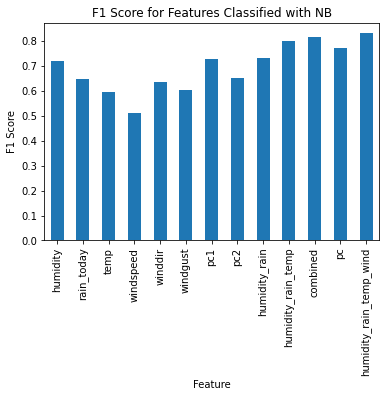

In [21]:
#create bar plot with comparison of f1 scores for features considered
inds=range(len(feature_names))
(dft_scores['F1']).plot.bar(tick_label=dft_scores['Features'])
plt.title('F1 Score for Features Classified with NB')
plt.xticks(inds,feature_names)
plt.xlabel('Feature')
plt.ylabel('F1 Score')

##### Best features for training are humidity rain and temperature combined, all features combined, and humidity, rain, temperature, and wind direction combined (all have similar performance)

## Model Training and 10-fold Cross Validation Scores

After training the classifier, we test on the unseen validation data using 10-fold cross validation and choose the F1 score as the metric for evaluating classifier accuracy

In [23]:
#choose feature and create corresponding labels
X = humidity_rain_temp_wind 
y = dft['Target'].to_numpy()

## Train without AdaBoost First

In [25]:
X_train = X
y_train = y

#define lists for holding score results
precision = []
recall = []
f1 = []

#define the three classifiers with best hyperparameters from Grid Search
clf = BernoulliNB(alpha=1)

clf2 = make_pipeline(StandardScaler(with_mean=False), LinearSVC(max_iter=10000, random_state=0, tol=1))

clf3 = DecisionTreeClassifier()

#use SMOTE to oversample the under represented class
oversample = SMOTE(k_neighbors=2)
X_train, y_train = oversample.fit_resample(X_train, y_train)

clf.fit(X_train, y_train)
#weighted average scorer code suggested by TA Joseph Gatto
scores = cross_val_score(clf, X_train, y_train, scoring = make_scorer(precision_score, average='weighted'), cv=10)
scores2 = cross_val_score(clf, X_train, y_train, scoring = make_scorer(recall_score, average='weighted'), cv=10)
scores3 = cross_val_score(clf, X_train, y_train, scoring = make_scorer(f1_score, average='weighted'), cv=10)
print("NB Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("NB Recall: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))
print("NB F1-score: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

precision.append(scores.mean())
recall.append(scores2.mean())
f1.append(scores3.mean())

clf2.fit(X_train, y_train)

scores4 = cross_val_score(clf2, X_train, y_train, scoring = make_scorer(precision_score, average='weighted'), cv=10)
scores5 = cross_val_score(clf2, X_train, y_train, scoring = make_scorer(recall_score, average='weighted'), cv=10)
scores6 = cross_val_score(clf2, X_train, y_train, scoring = make_scorer(f1_score, average='weighted'), cv=10)
print("SVM Precision: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std() * 2))
print("SVM Recall: %0.2f (+/- %0.2f)" % (scores5.mean(), scores5.std() * 2))
print("SVM F1-score: %0.2f (+/- %0.2f)" % (scores6.mean(), scores6.std() * 2))

precision.append(scores4.mean())
recall.append(scores5.mean())
f1.append(scores6.mean())

clf3.fit(X_train, y_train)

scores7 = cross_val_score(clf3, X_train, y_train, scoring = make_scorer(precision_score, average='weighted'), cv=10)
scores8 = cross_val_score(clf3, X_train, y_train, scoring = make_scorer(recall_score, average='weighted'), cv=10)
scores9 = cross_val_score(clf3, X_train, y_train, scoring = make_scorer(f1_score, average='weighted'), cv=10)
print("DTree Precision: %0.2f (+/- %0.2f)" % (scores7.mean(), scores7.std() * 2))
print("DTree Recall: %0.2f (+/- %0.2f)" % (scores8.mean(), scores8.std() * 2))
print("DTree F1-score: %0.2f (+/- %0.2f)" % (scores9.mean(), scores9.std() * 2))

precision.append(scores7.mean())
recall.append(scores8.mean())
f1.append(scores9.mean())

NB Precision: 0.75 (+/- 0.10)
NB Recall: 0.74 (+/- 0.11)
NB F1-score: 0.73 (+/- 0.11)
SVM Precision: 0.75 (+/- 0.04)
SVM Recall: 0.75 (+/- 0.05)
SVM F1-score: 0.75 (+/- 0.05)
DTree Precision: 0.83 (+/- 0.14)
DTree Recall: 0.82 (+/- 0.13)
DTree F1-score: 0.82 (+/- 0.14)


## Train with AdaBoost

In [29]:
X_train = X
y_train = y

#define lists for holding score results
precision_adaboost = []
recall_adaboost = []
f1_adaboost = []

#define the three classifiers with best hyperparameters from Grid Search
nb = BernoulliNB(alpha=1)
clf = AdaBoostClassifier(base_estimator=nb, learning_rate=1e-04, n_estimators=100)

svc = LinearSVC(max_iter=10000, random_state=0, tol=1)
clf2 = AdaBoostClassifier(base_estimator=svc,learning_rate=1e-04,n_estimators=100, algorithm ='SAMME')

dt = DecisionTreeClassifier()
clf3 = AdaBoostClassifier(base_estimator=dt, learning_rate=1e-04,n_estimators=10)

#use SMOTE to oversample the under represented class
oversample = SMOTE(k_neighbors=2)
X_train, y_train = oversample.fit_resample(X_train, y_train)

#weighted average scorer code suggested by TA Joseph Gatto
scores = cross_val_score(clf, X_train, y_train, scoring = make_scorer(precision_score, average='weighted'), cv=10)
scores2 = cross_val_score(clf, X_train, y_train, scoring = make_scorer(recall_score, average='weighted'), cv=10)
scores3 = cross_val_score(clf, X_train, y_train, scoring = make_scorer(f1_score, average='weighted'), cv=10)
print("NB Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("NB Recall: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))
print("NB F1-score: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

precision_adaboost.append(scores.mean())
recall_adaboost.append(scores2.mean())
f1_adaboost.append(scores3.mean())

scores4 = cross_val_score(clf2, X_train, y_train, scoring = make_scorer(precision_score, average='weighted'), cv=10)
scores5 = cross_val_score(clf2, X_train, y_train, scoring = make_scorer(recall_score, average='weighted'), cv=10)
scores6 = cross_val_score(clf2, X_train, y_train, scoring = make_scorer(f1_score, average='weighted'), cv=10)
print("SVM Precision: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std() * 2))
print("SVM Recall: %0.2f (+/- %0.2f)" % (scores5.mean(), scores5.std() * 2))
print("SVM F1-score: %0.2f (+/- %0.2f)" % (scores6.mean(), scores6.std() * 2))

precision_adaboost.append(scores4.mean())
recall_adaboost.append(scores5.mean())
f1_adaboost.append(scores6.mean())

scores7 = cross_val_score(clf3, X_train, y_train, scoring = make_scorer(precision_score, average='weighted'), cv=10)
scores8 = cross_val_score(clf3, X_train, y_train, scoring = make_scorer(recall_score, average='weighted'), cv=10)
scores9 = cross_val_score(clf3, X_train, y_train, scoring = make_scorer(f1_score, average='weighted'), cv=10)
print("DTree Precision: %0.2f (+/- %0.2f)" % (scores7.mean(), scores7.std() * 2))
print("DTree Recall: %0.2f (+/- %0.2f)" % (scores8.mean(), scores8.std() * 2))
print("DTree F1-score: %0.2f (+/- %0.2f)" % (scores9.mean(), scores9.std() * 2))

precision_adaboost.append(scores7.mean())
recall_adaboost.append(scores8.mean())
f1_adaboost.append(scores9.mean())

NB Precision: 0.75 (+/- 0.10)
NB Recall: 0.74 (+/- 0.11)
NB F1-score: 0.74 (+/- 0.12)
SVM Precision: 0.70 (+/- 0.05)
SVM Recall: 0.69 (+/- 0.06)
SVM F1-score: 0.69 (+/- 0.05)
DTree Precision: 0.84 (+/- 0.16)
DTree Recall: 0.83 (+/- 0.17)
DTree F1-score: 0.83 (+/- 0.17)


## Summary Table of Results

In [30]:
classifiers = ['Bernoulli NB','Linear SVM','Decision Tree']
dft_scores = pd.DataFrame(classifiers) 
dft_scores['F1'] = f1
dft_scores['F1_AdaBoost'] = f1_adaboost
dft_scores.columns = ['Classifiers','F1','F1_AdaBoost']

In [31]:
dft_scores

,Classifiers,F1,F1_AdaBoost
0,Bernoulli NB,0.733070,0.735848
1,Linear SVM,0.748949,0.694382
2,Decision Tree,0.824145,0.832888


Notice how we achieve a marginal improvement with AdaBoost added to the Naive Bayes and Decision Tree classifiers, but actually see a decrease in the classifier performance with the Linear SVM classifier. 83% prediction accuracy for rain the next day isn't too bad considering the limited data used to train the classifier!